# Lập trình bootstrap với Python

# 1bis: Chọn mẫu ngẫu nhiên chuỗi thời gian

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Bài thực hành này có thể xem như phụ lục mở rộng cho bài 1. Lần trước, ta đã tìm hiểu về uy trình sinh mẫu ngẫu nhiên có hoàn lại cho 1 dữ liệu với đơn vị quan sát là bệnh nhân và không có yếu tố thời gian. Trong bài 1 bis này Nhi sẽ bàn về vấn đề chọn mẫu ngẫu nhiên cho dữ liệu chuỗi thời gian.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Trong thí dụ minh họa này, Nhi có dữ liệu thô tín hiệu SpO2 của một bệnh nhân, được lấy mẫu ở tần số 10 Hz, và theo dõi liên tục trong khoảng thời gian 514 phút (khoảng 8.6 giờ). 

Dữ liệu được trình bày dưới dạng pandas DataFrame với hệ thống Datatime index chính xác đến Ngày/Tháng/Năm, Giờ/Phút/Giây/mili giây. Mỗi hàng trong cột spo2 tương ứng với 1 giá trị spO2 ghi nhận trong 1/10 giây. Cột period là nhãn định vị cho mỗi chu kì dài 60 phút, được đánh số thứ tự 0-9. Việc dán nhãn này cho phép mô tả về trình tự và cấu trúc của chuỗi dữ liệu. 

File dữ liệu được nén và có thể tải từ github của Nhi:
https://github.com/kinokoberuji/Statistics-Python-Tutorials/blob/master/Bootstrap/spo2.rar

In [5]:
def prepare_data(path = 'spo2.pkl', n_block = 10):
    
    with open(path, 'rb') as handle:
        seq = pickle.load(handle)
        
    seq.loc[seq > 100] = 100
    seq.loc[seq < 85] = 85
    
    ts_df = pd.DataFrame(seq)
    
    step = np.ceil(seq.index.shape[0]/n_block)
    lims = [seq.index[i] for i in [int(i*step) for i in range(n_block)]][1:]
    
    pals = sns.color_palette("husl", len(lims)+1).as_hex()
    
    periods = {k:v for k,v in zip(lims, range(len(lims)))}

    def period_mapping(value):
        for k, g in periods.items():
            if value <= k:
                return g
            
    ts_df['Period'] = ts_df.index.map(period_mapping)
    
    ts_df['Period'] = ts_df[['Period']].fillna(n_block - 1)
    
    return ts_df, pals

In [7]:
ts_df, pals = prepare_data(path = 'spo2.pkl')

In [8]:
ts_df

,spo2,Period
2017-07-28 22:15:00+02:00,94.0,0.0
2017-07-28 22:15:00.100000+02:00,94.0,0.0
2017-07-28 22:15:00.200000+02:00,94.0,0.0
2017-07-28 22:15:00.300000+02:00,94.0,0.0
2017-07-28 22:15:00.400000+02:00,94.0,0.0
...,...,...
2017-07-29 06:48:59.600000+02:00,95.0,9.0
2017-07-29 06:48:59.700000+02:00,95.0,9.0
2017-07-29 06:48:59.800000+02:00,95.0,9.0
2017-07-29 06:48:59.900000+02:00,95.0,9.0


Nội dung timestamp index xác nhận tần số lấy mẫu 10 Hz (10 giá trị/giây).

In [10]:
ts_df.index[:11]

DatetimeIndex([       '2017-07-28 22:15:00+02:00',
               '2017-07-28 22:15:00.100000+02:00',
               '2017-07-28 22:15:00.200000+02:00',
               '2017-07-28 22:15:00.300000+02:00',
               '2017-07-28 22:15:00.400000+02:00',
               '2017-07-28 22:15:00.500000+02:00',
               '2017-07-28 22:15:00.600000+02:00',
               '2017-07-28 22:15:00.700000+02:00',
               '2017-07-28 22:15:00.800000+02:00',
               '2017-07-28 22:15:00.900000+02:00',
                      '2017-07-28 22:15:01+02:00'],
              dtype='datetime64[ns, Europe/Brussels]', freq='100L')

Tổng cộng có 308401 đơn vị quan sát trong chuỗi

In [11]:
ts_df.shape[0]

308401

Quy đổi ra đơn vị thời gian, chuỗi này dài 514 phút, hay 8 giờ 34 phút

In [12]:
ts_df.shape[0]/10/60

514.0016666666667

In [18]:
ts_df.index[-1] - ts_df.index[0]

Timedelta('0 days 08:34:00')

Tiếp theo, Nhi viết hàm sau đây, nó cho phép vẽ một đồ thị tuyến kí (step-line plot) để trình bày diễn tiến của SpO2 theo thời gian; và được tô màu theo những phân đoạn mỗi 60 phút (1 giờ). 

In [19]:
def plot_spo2(ts_df: pd.DataFrame, pals, freq = 10):
    
    plt.rcParams.update({"font.size": 15})
    plt.rcParams['figure.figsize'] = 20,4
    
    time = np.arange(ts_df.shape[0])/freq/60
    
    for i in range(ts_df['Period'].unique().size):
        
        try:
            plt.fill_between(time,
                             np.repeat(np.min(ts_df['spo2'])-2, ts_df['spo2'].shape[0]),
                             ts_df.spo2, 
                             step="pre",
                             color = pals[i],
                             where=ts_df['Period'] == i,
                             alpha=0.8)
        except:
            continue

    plt.ylabel('SpO2 %')
    plt.xlabel('Thời gian (phút)')
    
    plt.plot(time,
                ts_df.spo2.values,
                drawstyle="steps", 
                alpha = 0.4,
                color = 'k')
    
    plt.hlines(y = 93,
               xmin = time.min(), 
               xmax = time.max(),
               linestyles= 'dashed',
               color = 'red')
        
    plt.show()

Đây là kết quả:

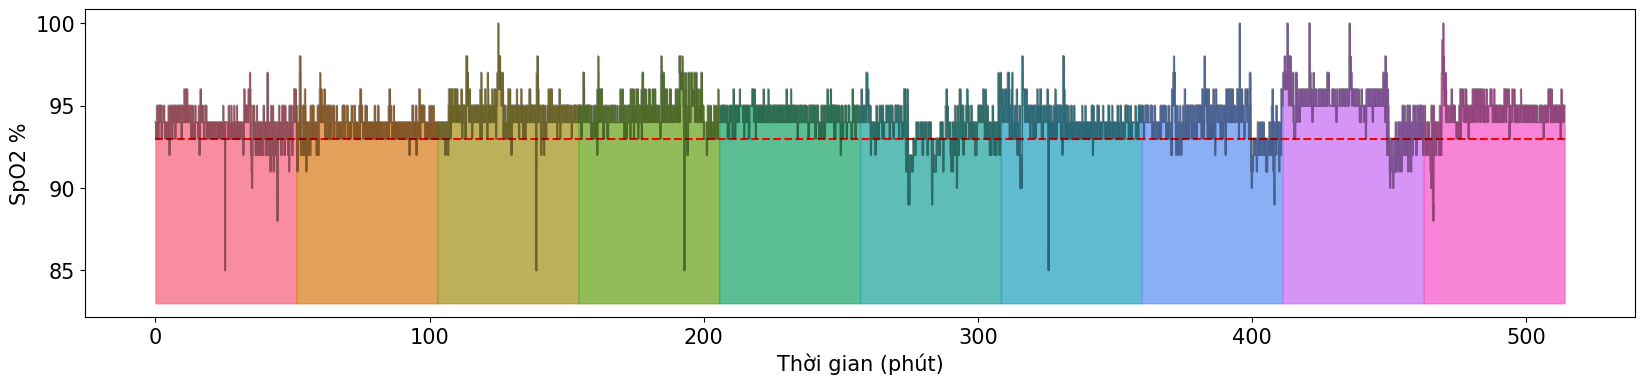

In [21]:
plot_spo2(ts_df, pals)

# Bootstrap cho chuỗi thời gian

Trước khi đi vào nội dung Bootstrap cho dữ liệu chuỗi thời gian, ta nhớ lại rằng nguyên lý của Bootstrap là một quy trình tái chọn mẫu ngẫu nhiên có hoàn lại.

Trên dữ liệu thông thường (không có yếu tố trình tự thời gian), ta chỉ cần thỏa mãn 3 yếu tố: Tính ngẫu nhiên, tính lặp lại, và cỡ mẫu đúng bằng với kích thước của mẫu nguyên thủy. Đây là một việc rất đơn giản,

Tuy nhiên, khi làm việc với dữ liệu chuỗi thời gian, có những sự tương đồng và khác biệt.

Về sự tương đồng: Cũng như dữ liệu thường, ta có thể xem chuỗi thời gian là không gian chọn mẫu. Việc chọn mẫu vẫn có tính chất ngẫu nhiên.

Nhưng có những khác biệt quan trọng sau đây, làm cho vấn đề trở nên phức tạp hơn:

+ Khác với dữ liệu thông thường, hiếm khi người ta quan tâm đến giá trị tại 1 thời điểm đơn lẻ trong chuỗi thời gian. Thông thường, ta muốn tập trung khảo sát một phân đoạn có độ dài xác định (còn gọi là cửa sổ quan sát). Thí dụ, trên chuỗi dữ liệu huyết áp theo dõi 2 lần/ngày trong suốt 2 tháng của 1 bệnh nhân, một bác sĩ có thể khảo sát ngẫu nhiên 1 khoảng thời gian là 7 ngày (1 tuần). Như vậy, đơn vị chọn mẫu không phải là thời điểm, mà là những khối (data block), phân đoạn (fragment, segment, epoch), hay cửa sổ (sampling window).

+ Trong cùng một cửa sổ/phân đoạn, các giá trị có trình tự nhất định theo thời gian; như vậy tính ngẫu nhiên áp dụng cho vị trí của cửa sổ/phân đoạn trên chuỗi dữ liệu toàn thể, nhưng không áp dụng cho các giá trị bên trong phân đoạn/cửa sổ chọn mẫu.

+ Về kích thước tương đồng và sự lặp lại: Tùy theo bài toán và quan điểm, người ta có thể đặt ra 2 bài toán:

## Bài toán 1: 

Trong bài toán này, mục tiêu của chúng ta là: 

Từ chuỗi thời gian toàn thể T ban đầu, ta sẽ rút ra ngẫu nhiên 1 phân đoạn w duy nhất (w có độ dài ngắn hơn T), thực hiện phân tích thống kê trên phân đoạn w này; lặp lại rất nhiều lần quy trình trên. 

Thí dụ: nếu bác sĩ muốn ước tính khoảng tin cậy của 1 trị số là SpO2 trung bình trong 1 giờ, anh/chị ta sẽ chọn kích thước cửa sổ w = 60 phút và rút ngẫu nhiên 1000 phân đoạn w này từ 1 chuổi toàn thể dài hơn 8h.

Nhi viết hàm random_seq_sample cho phép thực hiện quy trình trên: 

Hàm này cần 2 arguments là tổng kích thước của chuỗi toàn thể (total_length) và kích thước của phân đoạn/cửa sổ mục tiêu (block_size).

Hàm sẽ xuất ra một numpy array có nội dung là chuỗi indices, áp dụng nó cho dataframe gốc ta sẽ lấy được mẫu ngẫu nhiên cần thiết:

In [22]:
def random_seq_sample(tot_len: int, block_size: int):
    
    assert tot_len > block_size, f"Lỗi: Kích thước cửa sổ ={block_size} lớn hơn kích thước chuỗi ({tot_len})"
    
    start = np.random.randint(0, tot_len - block_size)
    end = start + block_size
    
    sample_idx = np.arange(start,end)
    
    return sample_idx

Nhi áp dụng hàm này 10 lượt cho một trường hợp giả định là chuỗi T dài 20 đơn vị quan sát, và ta cần chọn ngẫu nhiên phân đoạn kích thước = 4:

In [23]:
# Một chuỗi có 20 đơn vị quan sát, kích thước cửa sổ chọn mẫu = 5

for i in range(10):
    print(f"Iter_{i+1}:", random_seq_sample(20,4))

Iter_1: [13 14 15 16]
Iter_2: [5 6 7 8]
Iter_3: [1 2 3 4]
Iter_4: [ 8  9 10 11]
Iter_5: [0 1 2 3]
Iter_6: [ 9 10 11 12]
Iter_7: [4 5 6 7]
Iter_8: [14 15 16 17]
Iter_9: [2 3 4 5]
Iter_10: [ 9 10 11 12]


## Bài toán thứ hai

Bài toán này thú vị và khó hơn, mục tiêu là:

Tạo ra 1 hay nhiều chuỗi thời gian T' mới có kích thước đúng bằng với chuỗi dữ liệu gốc T, nhưng cấu tạo bên trong là sự ghép nối ngẫu nhiên/không liên tục của nhiều phân đoạn chọn mẫu w có độ dài ngắn hơn T và bằng nhau (Nội dung giữa những phân đoạn này có thể trùng lắp hoặc không). Sự trộn lẫn này có thể xem như một hình thức hoán vị. Sau đó phân tích thống kê trên toàn bộ chuỗi lớn T' này. 

Thí dụ: một bác sĩ muốn dựng mô hình Markov ẩn để biết xác suất chuyển tiếp giữa các giá trị huyết áp hằng ngày từ chuỗi dữ liệu T dài 90 ngày của một bệnh nhân, anh/chị ta có thể tạo ra 1000 phiên bản khác nhau của chuỗi toàn thể T này, nhưng bên trong là sự trộn lẫn các phân đoạn w dài 5 hay 10 ngày. 

Nhi viết 2 hàm cho 2 trường hợp: 

+ Hàm **moving_block_bootstrap**: Cho phép các phân đoạn có nội dung trùng lắp nhau một phần: 

+ Hàm **non_overlap_bootstrap**: Giữa các phân đoạn không được phép trùng lắp nhau, chúng hoàn toàn riêng lẻ.

Ta lại nhận thấy rằng mục tiêu chỉ có thể đạt được một cách hoàn hảo nếu kích thước của chuỗi T là một bội số của kích thước của phân đoạn (cửa sổ chọn mẫu) w (T.size chia hết cho w.size). Trong trường hợp không chia hết, chắc chắn sẽ có phần dư với kích thước nhỏ hơn w.size. Yếu tố phần dư được quy định bằng argument residual = True/False

In [31]:
def moving_block_bootstrap(tot_len: int, block_size: int, residual = True):
    
    assert tot_len > block_size, f"Lỗi: Kích thước cửa sổ = {block_size} lớn hơn kích thước chuỗi ({tot_len})"
    
    if residual:
        n_blocks = int(np.ceil(tot_len / block_size))
    else:
        n_blocks = tot_len//block_size
    
    nexts = np.repeat([np.arange(0, block_size)], n_blocks, axis=0)

    last = tot_len - block_size
    
    blocks = np.random.randint(0, last, (n_blocks, 1))
    
    sample_idx = (blocks + nexts).flatten()[:tot_len]
    
    return sample_idx

Thử hàm này với chế độ có lấy phần dư, trên 1 chuỗi T dài 20 đơn vị, và kích thước cửa sổ chọn mẫu w = 3, ta có:

In [32]:
# Có lấy phần dư:

idx = moving_block_bootstrap(20,3, True)

idx

array([13, 14, 15,  6,  7,  8,  7,  8,  9, 14, 15, 16,  4,  5,  6,  5,  6,
        7,  5,  6])

Như ta thấy, vì có lấy phần dư, dù 20 không chia hết cho 3, ta vẫn tạo ra được chuỗi T' dài đúng 20, nhưng đoạn cuối T' không đảm bảo kích thước w = 3, nó chỉ có 2 phần tử là 5,6

In [33]:
idx.shape

(20,)

Thử lạp lại 10 lượt hàm này:

In [18]:
for i in range(10):
    print(f"Iter_{i+1}:", moving_block_bootstrap(20,3, True))

Iter_1: [10 11 12 12 13 14 11 12 13  8  9 10 14 15 16  8  9 10 10 11]
Iter_2: [ 0  1  2 15 16 17 11 12 13  8  9 10  2  3  4 11 12 13 16 17]
Iter_3: [ 3  4  5 10 11 12 15 16 17 10 11 12  8  9 10  0  1  2 13 14]
Iter_4: [ 9 10 11  2  3  4  9 10 11  4  5  6  0  1  2  1  2  3 11 12]
Iter_5: [12 13 14  2  3  4  8  9 10 16 17 18  5  6  7 16 17 18 12 13]
Iter_6: [16 17 18 13 14 15  7  8  9  3  4  5  6  7  8  6  7  8 10 11]
Iter_7: [14 15 16 15 16 17 15 16 17  0  1  2 15 16 17  0  1  2 12 13]
Iter_8: [ 2  3  4 12 13 14 12 13 14 14 15 16  6  7  8  9 10 11  5  6]
Iter_9: [ 7  8  9 12 13 14  1  2  3 11 12 13  4  5  6  9 10 11  6  7]
Iter_10: [ 9 10 11  5  6  7 16 17 18  1  2  3  0  1  2 12 13 14 11 12]


Ta làm cùng thí dụ trên, nhưng không lấy phần dư, lúc này ta chỉ tạo ra được chuỗi T' dài tối đa 18 thay vì 20 (bỏ phần dư).

In [24]:
# Không lấy phần dư:

idx = moving_block_bootstrap(20,3, False)

idx

array([12, 13, 14, 14, 15, 16,  2,  3,  4,  4,  5,  6,  8,  9, 10, 11, 12,
       13])

In [25]:
for i in range(10):
    print(f"Iter_{i+1}:", moving_block_bootstrap(20,3, False))

Iter_1: [ 3  4  5  7  8  9  1  2  3  8  9 10  1  2  3  9 10 11]
Iter_2: [14 15 16  5  6  7  0  1  2 14 15 16  9 10 11  6  7  8]
Iter_3: [16 17 18 15 16 17  2  3  4 16 17 18  8  9 10  6  7  8]
Iter_4: [ 3  4  5 16 17 18  4  5  6  4  5  6  8  9 10  6  7  8]
Iter_5: [10 11 12  9 10 11  8  9 10  5  6  7  0  1  2 10 11 12]
Iter_6: [ 8  9 10  5  6  7 11 12 13  0  1  2  2  3  4  1  2  3]
Iter_7: [14 15 16 10 11 12 15 16 17  1  2  3 11 12 13  2  3  4]
Iter_8: [ 1  2  3  8  9 10 14 15 16  6  7  8 14 15 16 11 12 13]
Iter_9: [10 11 12 14 15 16 10 11 12 14 15 16 13 14 15 13 14 15]
Iter_10: [10 11 12  5  6  7  2  3  4  0  1  2 15 16 17 16 17 18]


Ta áp dụng hàm trên cho chuỗi SpO2, với kích thước cửa sổ w = 30 phút (10* 60 * 30). Kết quả như sau:

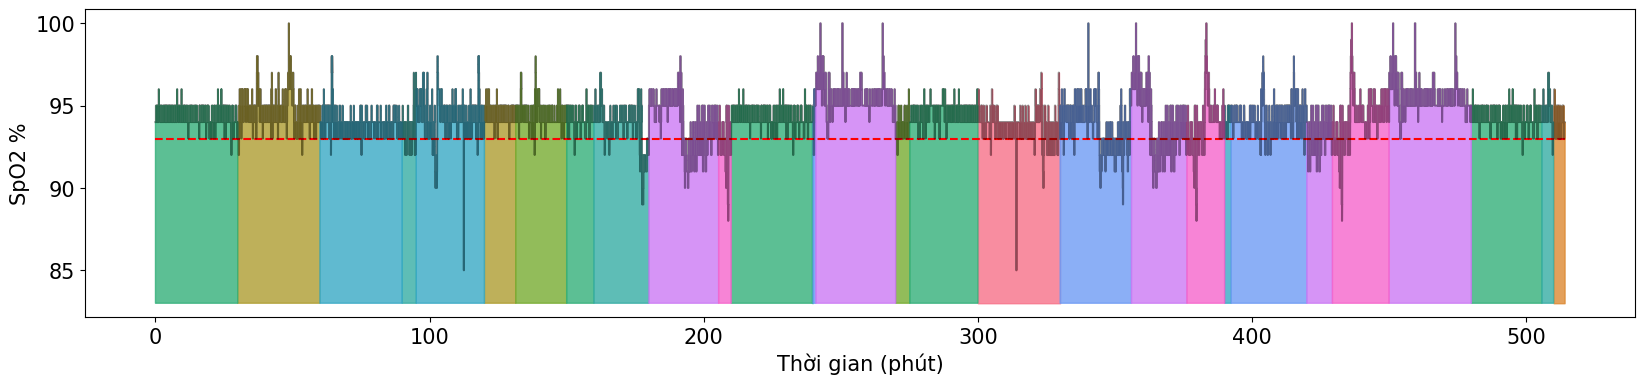

['#f77189',
 '#dc8932',
 '#ae9d31',
 '#77ab31',
 '#33b07a',
 '#36ada4',
 '#38a9c5',
 '#6e9bf4',
 '#cc7af4',
 '#f565cc']

In [35]:
idx = moving_block_bootstrap(ts_df.shape[0], 10*60*30, True)

plot_spo2(ts_df.iloc[idx], pals)

pals

Như ta thấy, trình tự các chu kì 60 phút ban đầu hoàn toàn bị đảo lộn, hình ảnh của chuỗi T' là một sự hoán vị, trộn lẫn các phân đoạn dài 30 phút, và trình tự thời gian chỉ được đảm bảo trong từng phân đoạn.

Bây giờ ta thử hàm thứ 2, không cho phép có sự trùng lắp giữa các phân đoạn:

In [37]:
def non_overlap_bootstrap(tot_len: int, block_size: int):
    
    assert tot_len > block_size, f"Lỗi: Kích thước cửa sổ = {block_size} lớn hơn kích thước chuỗi ({tot_len})"
    
    n_blocks = tot_len//block_size
    
    nexts = np.repeat([np.arange(0, block_size)], n_blocks, axis=0)
        
    blocks = np.random.permutation(np.arange(0, tot_len, block_size)).reshape(-1, 1)
    
    sample_idx = (blocks[:-1] + nexts).flatten()[:tot_len]
    
    sample_idx = sample_idx[sample_idx < sample_idx.shape[0]]
    
    return sample_idx

In [38]:
idx = non_overlap_bootstrap(20,3)

idx

array([ 6,  7,  8, 12, 13, 14, 15, 16, 17,  0,  1,  2,  3,  4,  5])

In [39]:
for i in range(10):
    print(f"Iter_{i+1}:", non_overlap_bootstrap(20,3))

Iter_1: [ 3  4  5 12 13 14  6  7  8  0  1  2  9 10 11]
Iter_2: [ 0  1  2 15 16 17  3  4  5  9 10 11  6  7  8]
Iter_3: [ 9 10 11  6  7  8 12 13 14 15 16 17  0  1  2]
Iter_4: [ 6  7  8  0  1  2 12 13 14 15 16 17  3  4  5]
Iter_5: [ 3  4  5  6  7  8  9 10 11  0  1  2 15 16 17]
Iter_6: [12 13 14  9 10 11  6  7  8  3  4  5 15 16 17]
Iter_7: [ 9 10 11  0  1  2 12 13 14  3  4  5 15 16 17]
Iter_8: [ 3  4  5  0  1  2 12 13 14 15 16 17  6  7  8]
Iter_9: [15 16 17  9 10 11  0  1  2  3  4  5 12 13 14]
Iter_10: [ 9 10 11  6  7  8  0  1  2  3  4  5 15 16 17]


Hình ảnh của kết quả cũng tương tự như trên, nhưng ta biết rằng trong chuỗi T' này mỗi giá trị chỉ xuất hiện 1 lần duy nhất, vì giữa các phân đoạn không có sự trùng lặp nào cả.

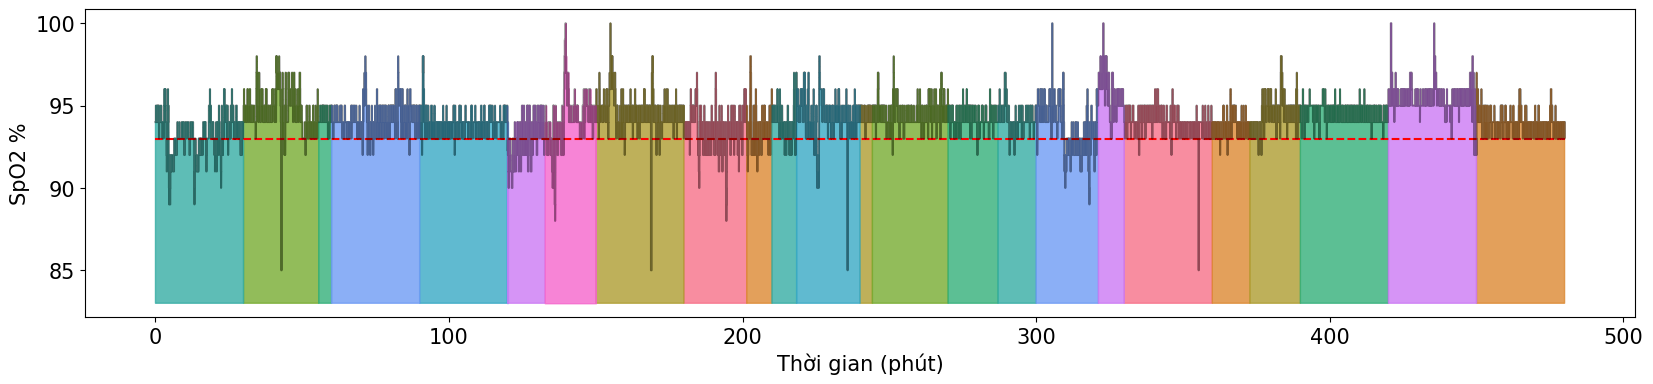

['#f77189',
 '#dc8932',
 '#ae9d31',
 '#77ab31',
 '#33b07a',
 '#36ada4',
 '#38a9c5',
 '#6e9bf4',
 '#cc7af4',
 '#f565cc']

In [40]:
idx = non_overlap_bootstrap(ts_df.shape[0],10*60*30)

plot_spo2(ts_df.iloc[idx], pals)

pals

Bài thực hành đến đây là hết, hẹn gặp các bạn lần sau.